<a href="https://colab.research.google.com/github/ErikFantomex/Redes-Neuronales/blob/main/ProyectoRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
import pandas as pd
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sys
import unicodedata
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet as wn
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-procesamiento de datos

In [ ]:
#Creamos una variable df con el dataset
df = pd.read_csv("/content/drive/MyDrive/datasets/haha_2021_train.csv")

In [ ]:
df.drop(["votes_no","votes_1", "votes_2", "votes_3", "votes_4", "votes_5","humor_mechanism"],
          axis=1,
          inplace=True)

In [ ]:
df.head()

,id,text,is_humor,humor_rating,humor_target
0,tweet1,Niveles de retraso mental: \n\n— Bajo.\n— Medi...,1,1.5,NaN
1,tweet2,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1.5,NaN
2,tweet3,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,2.6,NaN
3,tweet4,No se porqué me hago la cabeza deooos,0,NaN,NaN
4,tweet5,Quisiera saber que hago durante la siesta de l...,0,NaN,NaN


In [ ]:
df.text.isnull().any() # no missing values in is_sarcastic column
df.is_humor.isnull().any() # no missing values in headline column

False

In [ ]:
df['text'] = df.text.apply(lambda x:x.lower())  # convert all words in headline into lower case 
df['text'] = df.text.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))  # remove all punctuation 

In [ ]:
df.head()

,id,text,is_humor,humor_rating,humor_target
0,tweet1,niveles de retraso mental — bajo — medio — alt...,1,1.5,NaN
1,tweet2,—vamos luke desenfunda tu sable demuestra tu o...,1,1.5,NaN
2,tweet3,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,2.6,NaN
3,tweet4,no se porqué me hago la cabeza deooos,0,NaN,NaN
4,tweet5,quisiera saber que hago durante la siesta de l...,0,NaN,NaN


In [ ]:
df = df.assign(CleanText="", TokenizeText="", NoStopwords="", LemmaText="")

In [ ]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string

df['CleanText'] = df['text'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def Tokenizacion(tweet):
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)
  return tweet_tokens



In [ ]:
for i in range(len(df)):
  df['TokenizeText'][i] = Tokenizacion(df['CleanText'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
#Concatenar las stopwords aplicándose a una cuenta que genera contenido en inglés y español
stop_words = stop_words_sp | stop_words_en

In [ ]:
df['NoStopwords'] = df['TokenizeText'].apply(lambda x: [item for item in x if item not in stop_words])


In [ ]:
df.head()

,id,text,is_humor,humor_rating,humor_target,CleanText,TokenizeText,NoStopwords,LemmaText
0,tweet1,niveles de retraso mental — bajo — medio — alt...,1,1.5,NaN,niveles de retraso mental bajo medio alto elev...,"[niveles, de, retraso, mental, bajo, medio, al...","[niveles, retraso, mental, bajo, medio, alto, ...",
1,tweet2,—vamos luke desenfunda tu sable demuestra tu o...,1,1.5,NaN,vamos luke desenfunda tu sable demuestra tu od...,"[vamos, luke, desenfunda, tu, sable, demuestra...","[vamos, luke, desenfunda, sable, demuestra, od...",
2,tweet3,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,2.6,NaN,te ofrezco algo agua café mi corazón mi vida e...,"[te, ofrezco, algo, agua, café, mi, corazón, m...","[ofrezco, agua, café, corazón, vida, entera, a...",
3,tweet4,no se porqué me hago la cabeza deooos,0,NaN,NaN,no se porqué me hago la cabeza deooos,"[no, se, porqué, me, hago, la, cabeza, deooos]","[porqué, hago, cabeza, deooos]",
4,tweet5,quisiera saber que hago durante la siesta de l...,0,NaN,NaN,quisiera saber que hago durante la siesta de l...,"[quisiera, saber, que, hago, durante, la, sies...","[quisiera, saber, hago, siesta, levanto, cansa...",


In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

df['LemmaText'] = df['NoStopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 


In [ ]:
df2 = df[df['humor_target'].isna() != True]

In [ ]:
topicos = np.unique(df2['humor_target'])

In [ ]:
topics = []
for element in topicos:
    if element not in topics:
        topics.append(element)

In [ ]:
len(topics)

53

In [ ]:
dfLDA = df[df['humor_rating'].isna() != True]

In [ ]:
dfLDA['humor_rating'] = dfLDA['humor_rating'].round()
dfLDA['humor_rating'] = np.array(dfLDA['humor_rating'], dtype=np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/

In [ ]:
dfLDA.head()

,id,text,is_humor,humor_rating,humor_target,CleanText,TokenizeText,NoStopwords,LemmaText
0,tweet1,niveles de retraso mental — bajo — medio — alt...,1,2,NaN,niveles de retraso mental bajo medio alto elev...,"[niveles, de, retraso, mental, bajo, medio, al...","[niveles, retraso, mental, bajo, medio, alto, ...","[niveles, retraso, mental, bajo, medio, alto, ..."
1,tweet2,—vamos luke desenfunda tu sable demuestra tu o...,1,2,NaN,vamos luke desenfunda tu sable demuestra tu od...,"[vamos, luke, desenfunda, tu, sable, demuestra...","[vamos, luke, desenfunda, sable, demuestra, od...","[vamos, luke, desenfunda, sable, demuestra, od..."
2,tweet3,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,3,NaN,te ofrezco algo agua café mi corazón mi vida e...,"[te, ofrezco, algo, agua, café, mi, corazón, m...","[ofrezco, agua, café, corazón, vida, entera, a...","[ofrezco, agua, café, corazón, vida, enteron, ..."
6,tweet7,—buenas don pepe ¿me vende un litro de leche —...,1,2,NaN,buenas don pepe me vende un litro de leche ent...,"[buenas, don, pepe, me, vende, un, litro, de, ...","[buenas, pepe, vende, litro, leche, entera, si...","[buenas, pepe, vende, litro, leche, enteron, s..."
12,tweet13,20cosasquehacerantesdemorir enseñarles la dife...,1,3,NaN,20cosasquehacerantesdemorir enseñarles la dife...,"[20cosasquehacerantesdemorir, enseñarles, la, ...","[20cosasquehacerantesdemorir, enseñarles, dife...","[20cosasquehacerantesdemorir, enseñarles, dife..."


In [ ]:
# initialise the count vectorizer

vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
                            
# join the processed data to be vectorised no_stopwords

vectors = []

for index, row in df.iterrows():
    vectors.append(", ".join(row[8]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)

  (0, 80544)	1
  (0, 102636)	1
  (0, 74040)	1
  (0, 11284)	1
  (0, 73004)	1
  (0, 4701)	1
  (0, 40066)	1
  (0, 101700)	1
  (1, 123608)	1
  (1, 68456)	1
  (1, 32930)	1
  (1, 104884)	1
  (1, 32254)	1
  (1, 82936)	1
  (1, 90743)	1
  (1, 64328)	1
  (1, 84360)	1
  (1, 108539)	1
  (1, 114826)	1
  (1, 85522)	1
  (1, 66642)	1
  (1, 106741)	1
  (2, 83070)	1
  (2, 2632)	1
  (2, 16047)	1
  :	:
  (23997, 115407)	1
  (23997, 90658)	1
  (23997, 115428)	1
  (23997, 86193)	1
  (23997, 130876)	1
  (23997, 75005)	1
  (23997, 4479)	1
  (23997, 118656)	1
  (23997, 69956)	1
  (23997, 120033)	1
  (23998, 27947)	1
  (23998, 4080)	1
  (23998, 80229)	1
  (23998, 98892)	1
  (23998, 23579)	1
  (23999, 27562)	1
  (23999, 973)	1
  (23999, 73288)	1
  (23999, 59632)	1
  (23999, 67741)	1
  (23999, 45290)	1
  (23999, 943)	1
  (23999, 53829)	1
  (23999, 22530)	1
  (23999, 121869)	1


# LDA

In [ ]:
#LDA Model

lda_model = LatentDirichletAllocation(n_components = 5, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names
topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

dfLDA = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(dfLDA.head(10))

,id,text,is_humor,humor_rating,humor_target,CleanText,TokenizeText,NoStopwords,LemmaText,Topic1,Topic2,Topic3,Topic4,Topic5,Dominant_topic
0,tweet1,niveles de retraso mental — bajo — medio — alt...,1,1.5,NaN,niveles de retraso mental bajo medio alto elev...,"[niveles, de, retraso, mental, bajo, medio, al...","[niveles, retraso, mental, bajo, medio, alto, ...","[niveles, retraso, mental, bajo, medio, alto, ...",0.02,0.91,0.02,0.02,0.02,2
1,tweet2,—vamos luke desenfunda tu sable demuestra tu o...,1,1.5,NaN,vamos luke desenfunda tu sable demuestra tu od...,"[vamos, luke, desenfunda, tu, sable, demuestra...","[vamos, luke, desenfunda, sable, demuestra, od...","[vamos, luke, desenfunda, sable, demuestra, od...",0.01,0.95,0.01,0.01,0.01,2
2,tweet3,¿te ofrezco algo ¿agua café mi corazón mi vid...,1,2.6,NaN,te ofrezco algo agua café mi corazón mi vida e...,"[te, ofrezco, algo, agua, café, mi, corazón, m...","[ofrezco, agua, café, corazón, vida, entera, a...","[ofrezco, agua, café, corazón, vida, enteron, ...",0.93,0.02,0.02,0.02,0.02,1
3,tweet4,no se porqué me hago la cabeza deooos,0,NaN,NaN,no se porqué me hago la cabeza deooos,"[no, se, porqué, me, hago, la, cabeza, deooos]","[porqué, hago, cabeza, deooos]","[porqué, hago, cabeza, deooos]",0.80,0.05,0.05,0.05,0.05,1
4,tweet5,quisiera saber que hago durante la siesta de l...,0,NaN,NaN,quisiera saber que hago durante la siesta de l...,"[quisiera, saber, que, hago, durante, la, sies...","[quisiera, saber, hago, siesta, levanto, cansa...","[quisiera, saber, hago, siesta, levanto, cansa...",0.03,0.90,0.03,0.03,0.03,2
5,tweet6,la persona que te dice que no se arrepiente de...,0,NaN,NaN,la persona que te dice que no se arrepiente de...,"[la, persona, que, te, dice, que, no, se, arre...","[persona, dice, arrepiente, vida, toma, alcoho...","[persona, dice, arrepiente, vida, toma, alcoho...",0.91,0.02,0.02,0.02,0.02,1
6,tweet7,—buenas don pepe ¿me vende un litro de leche —...,1,2.5,NaN,buenas don pepe me vende un litro de leche ent...,"[buenas, don, pepe, me, vende, un, litro, de, ...","[buenas, pepe, vende, litro, leche, entera, si...","[buenas, pepe, vende, litro, leche, enteron, s...",0.02,0.02,0.94,0.02,0.02,3
7,tweet8,meeee aburro,0,NaN,NaN,meeee aburro,"[meee, aburro]","[meee, aburro]","[meee, aburro]",0.10,0.10,0.10,0.10,0.60,5
8,tweet9,macri le dijo las gordas que usar calzas está ...,0,NaN,NaN,macri le dijo las gordas que usar calzas está ...,"[macri, le, dijo, las, gordas, que, usar, calz...","[macri, dijo, gordas, usar, calzas, bien]","[macri, dijo, gordas, usar, calzas, bien]",0.03,0.03,0.03,0.03,0.87,5
9,tweet10,javier chicalito hernandez 7,0,NaN,NaN,javier chicalito hernandez,"[javier, chicalito, hernandez]","[javier, chicalito, hernandez]","[javier, chicalito, hernandez]",0.07,0.07,0.07,0.73,0.07,4


In [ ]:
# index names
#docnames = ['Doc' + str(i) for i in range(len(dfB4LDA))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,topic,relevance_score
00 cosas,Topic4,1.199971
00 d3,Topic4,3.203079
00 dejar,Topic3,1.199962
00 dosogas,Topic5,1.199921
00 llegué,Topic5,1.199819
...,...,...
ｓｅ ｄｅｔｕｖｏ,Topic1,1.199992
ｓｏｍｏｓ ｃｏｕｓｉｎｓ,Topic1,1.199992
ｓｕ ｐｒｉｍｏ,Topic1,1.199992
ｕｎ ｆｕｃｋ,Topic1,1.199992


In [ ]:
banned = ['Topic']
tmp = tmp.replace(dict(zip(banned,['']*len(banned))),regex=True)

In [ ]:
tmp["topic"] = tmp["topic"].astype(int) 
tmp.head()

,topic,relevance_score
00 cosas,4,1.199971
00 d3,4,3.203079
00 dejar,3,1.199962
00 dosogas,5,1.199921
00 llegué,5,1.199819


In [ ]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,5,[ja ja]
1,4,[buen día]
2,6,[chistes humor]
3,2,[buenos días]
4,3,[chistes rt]


In [ ]:
results = dfLDA.groupby(['Dominant_topic', 'is_humor']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'is_humor', 'humor_rating']]
graph_results = graph_results.pivot(index='topic_name', columns='is_humor', values='humor_rating').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

is_humor,0,1
topic_name,,
buen día,0,1783
buenos días,0,1827
chistes rt,0,1890
ja ja,0,1883


In [ ]:
graph_results=graph_results.drop(graph_results.index[3])
display(graph_results)

is_humor,0,1
topic_name,,
buen día,0,1783
buenos días,0,1827
chistes rt,0,1890


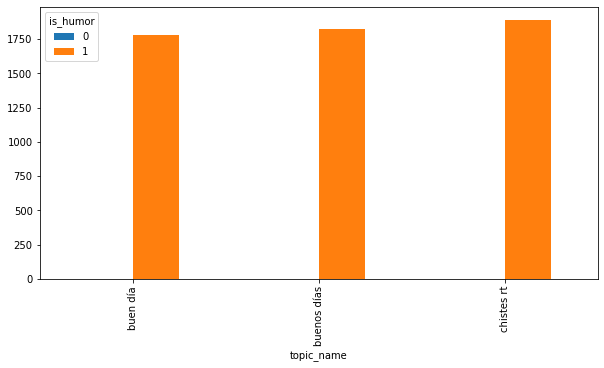

In [ ]:
fig = graph_results.plot.bar(rot=90, figsize=(10,5))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight', dpi=300)

#Redes neuronales modelo secuencial 


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

import time



In [ ]:


#model = Sequential([
#    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#    tf.keras.layers.Dense(units = 14, activation = 'relu'),
#    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
#])

#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



In [ ]:
#model.summary()

In [ ]:
#start_time = time.time()

#num_epochs = 10
#history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(valid_padded, y_valid))

#final_time = (time.time()- start_time)/60
#print(f'The time in minutos: {final_time}')

#polynomial regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing


In [ ]:

scaler = preprocessing.StandardScaler()
degree=9
polyreg_scaled=make_pipeline(PolynomialFeatures(degree),scaler,LinearRegression())
polyreg_scaled.fit(X,y)

NameError: ignored


#random forest classifier



In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import seaborn
ord_enc = OrdinalEncoder()
